### LIBRARIES

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
df1 = pd.read_csv("D:/University/2022-2023/HK2/thuThapVaTienXuLyDuLieu/fat_preprocessing/comments.csv", encoding="utf-8")

In [10]:
df1.head()

,product_id,comment_id,title,thank_count,customer_id,rating,comment
0,74021317,12559756,Cực kì hài lòng,313,22051463,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,74021317,16979365,Cực kì hài lòng,6,27791831,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,74021317,14069617,Cực kì hài lòng,25,17748750,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,74021317,8569824,Cực kì hài lòng,57,410797,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,74021317,18368714,Cực kì hài lòng,0,28545286,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


In [11]:
profile = ProfileReport(df1)
profile.get_description()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

{'analysis': {'title': 'Pandas Profiling Report',
  'date_start': datetime.datetime(2023, 4, 2, 11, 5, 51, 643465),
  'date_end': datetime.datetime(2023, 4, 2, 11, 6, 4, 674403),
  'duration': datetime.timedelta(seconds=13, microseconds=30938)},
 'table': {'n': 141281,
  'n_var': 7,
  'memory_size': 7911864,
  'record_size': 56.000905995852236,
  'n_cells_missing': 38022,
  'n_vars_with_missing': 2,
  'n_vars_all_missing': 0,
  'p_cells_missing': 0.038446176667168874,
  'types': {'Numeric': 4, 'Categorical': 3},
  'n_duplicates': 19411,
  'p_duplicates': 0.13739285537333398},
 'variables': {'product_id': {'n_distinct': 1974,
   'p_distinct': 0.013972154783728881,
   'is_unique': False,
   'n_unique': 0,
   'p_unique': 0.0,
   'type': 'Numeric',
   'hashable': True,
   'value_counts_without_nan': 53095307     300
   74021317     200
   8885995      200
   77105730     200
   117254517    200
               ... 
   207494295      2
   204957471      2
   206795253      2
   202961772    

In [12]:
df1['rating'].value_counts()

5    114514
4     14295
3      5276
1      4495
2      2701
Name: rating, dtype: int64

In [13]:
df1.shape

(141281, 7)

### Phân chia theo nhóm
Ta sẽ chia bộ dữ liệu theo thành từng nhóm (class), trong đó:
- 1-2: rating không thích
- 3: rating trung tính
- 4-5: rating thích

In [14]:
df_notlike = df1[df1['rating'] < 3 ]

In [15]:
df_neutral= df1[df1['rating'] == 3 ]

In [16]:
df_like = df1[df1['rating'] > 3 ]

### CHECK ISNULL

In [17]:
df2 = df1[["rating","comment"]].copy()

In [18]:
df2.isnull().sum()

rating         0
comment    38018
dtype: int64

In [19]:
df_isnull = df2[df2['comment'].isnull()]

In [20]:
df_isnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38018 entries, 770 to 141280
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   38018 non-null  int64 
 1   comment  0 non-null      object
dtypes: int64(1), object(1)
memory usage: 891.0+ KB


In [21]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5         35055
1       4          2906
2       3            45
3       1             9
4       2             3


### CHECK AND DROP DUPLICATED COMMENTS

In [22]:
df3 = df1[~df1['comment'].isnull()]

In [23]:
df3.duplicated().sum()

17264

In [24]:
df3.drop_duplicates(inplace=True)

In [25]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85999 entries, 0 to 141277
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   85999 non-null  int64 
 1   comment_id   85999 non-null  int64 
 2   title        85996 non-null  object
 3   thank_count  85999 non-null  int64 
 4   customer_id  85999 non-null  int64 
 5   rating       85999 non-null  int64 
 6   comment      85999 non-null  object
dtypes: int64(5), object(2)
memory usage: 5.2+ MB


In [26]:
for index, row in df3.sample(50).iterrows():
    print(row['comment'])

Sách khá ok
Chất lượng giấy tốt trắng- sáng, mực in rõ ràng
Nội dung mình chưa xem qua, nên không nx
Nhân viên bên ghn giao hàng rất lịch sự, mình đánh giá cao khoảng này
Cá nhân mình cảm thấy không hài lòng với lắm với cách tiki đóng gói sản phẩm. Mong tiki sẽ khắc phục
Lần sau, mình sẽ tiếp tục ủng hộ tiki
Shop hiếu cái miếng đánh dấu trang sách của em rồi huhu
sách in quá xấu, hình minh họa nhòe mà xấu
Chất lượng tốt
Giao khá nhanh, mới đặt trưa hôm trước thì sáng hôm sau đã có(dù là chủ nhật), về hình thức thì nhìn sơ qua không bị lỗi hay gì. Nội dung thì có lẽ ai cũng biết :v
Giao hàng nhanh, đóng gói sơ sài. Chỉ nhét sách vào hộp thôi. May là sách vẫn không sao, sách mới, k có seal. Không quá khi nói rằng mình nghĩ đây là 1 tác phẩm xuất sắc. Ngay từ đầu, mình cảm nhận được sự trầm lắng, nhẹ nhàng, hơi u buồn và nỗi thương cảm nhẹ cho cậu bé. Cách viết và mạch truyện khá lôi cuốn, tựa như một bức thư, nhật ký hay lời tâm sự của nhân vật chính. Đến cuối, mình không khỏi buồn, có c

In [27]:
df3.shape

(85999, 7)

### KEEP RATING AND COMMENT DATA

In [28]:
df4 = df3[['rating','comment']]

In [29]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['negative', 'neutral', 'positive']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [30]:
df4.reset_index(drop=True, inplace=True)

In [31]:
df4.head()

,comment,class
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",positive
1,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",positive
2,"Bìa cực xinh, tiki giao hàng nhanh, sách không...",positive
3,"Sách lúc nhận hình thức rất ổn, không cong vên...",positive
4,Một cuốn sách rất đáng đọc về tình yêu thương ...,positive


In [32]:
df4.isnull().sum()

comment    0
class      0
dtype: int64

In [33]:
df4['class'].value_counts()

positive    76005
negative     5666
neutral      4328
Name: class, dtype: int64

### CLEAN TEXT

In [34]:
from processing import *

In [35]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

In [36]:
from processing import processing_text

Convert dask df to pd df

In [37]:
# Create a dask dataframe from the pandas dataframe
ddf = dd.from_pandas(df4, npartitions=16)
ddf = ddf.map_partitions(processing_text)
# Convert the dask dataframe to pandas dataframe
with ProgressBar():
    df = ddf.compute(num_workers=7)
del ddf

[########################################] | 100% Completed | 366.53 s


In [38]:
for index, row in df.sample(100).iterrows():
    print(row['processed_text'])

sách câu_chuyện quan_điểm rất_mới tối_giản toàn_diện câu nhẹ_nhàng
nội sách tiêng sách màu nâu_đen tái_bản không_rõ cập_nhật như_bản bìa vàng chỉnh_lý không hơi_thất vọng sợ cũ chỗ lỗi_thời cố tái_bản bìa vàng
sách thiết_kế đẹp giấy nội hàng hài_lòng

bọc sách hư sách chán chả đọc
sách tỉnh sách bọc màng sách bị_nhàu nát cực_kỳ hài_lòng chất_lượng sách nội hình_thức giúp_ích thời cửa_hàng địa_phương hút khách_hàng như_nào

hàng sách đẹp
sách xinhhhh xĩu bọc hàng rất_cẩn thận sách không_bị hàng tặng sách mùi sách thơm lắm
hàng cực đóng_gói cẩn_thận sách
đọc quyển học đọc đổi quan_điểm rạch_ròi như_sergio phân_tích bổng thần_thánh_hóa kì_diệu đo_lường vọng làm_việc hiệu_quả thời sergio
sách đẹp dày có_lẽ nội lắm vô_dụng hơi_sơ sài góc mặt tóc tý mắt_mũi miệng manga nổi_tiếng cảnh lắm
sách gọn nội rất_gì không_đọc uổng lắm đọc cười
nội sách viết hơi_và trùng khúc khúc hơi_cảm kiểu nhiên đọc cũng_khá
bọc đẹp hàng trễ
sách đẹp đúng_hạn dễ_chịu bì
chất_lượng tốt giá
tuyệt_vời tủ_sách đình đọ

In [39]:
df.reset_index(drop=True, inplace=True)

In [40]:
df_final = df[['processed_text','class']]

In [41]:
df_final.head()

,processed_text,class
0,lấp hạnh_phúc vết nứt ủi chữa vỡ trái câu_chuy...,positive
1,chê gói hàng quá_hàng không_bị hư tẹo hơi_sơ s...,positive
2,bìa cực hàng sách không_bị nhăn góc gãy cạnh b...,positive
3,sách hình_thức rất_ổn không_vênh xước gãy đơn ...,positive
4,sách rất_đáng đọc tình_yêu_thương mất_mát gợi_...,positive


In [42]:
df_final['processed_text'].loc[1]

'chê gói hàng quá_hàng không_bị hư tẹo hơi_sơ sài không_bọc chống xóc sách rewiew sách jhas viết kiểu đọc không_chán sư khám_phá nỗi đau'

In [43]:
df_final.to_csv('comment_final.csv')

### VISUALIZE USING WORDCLOUD

Negative

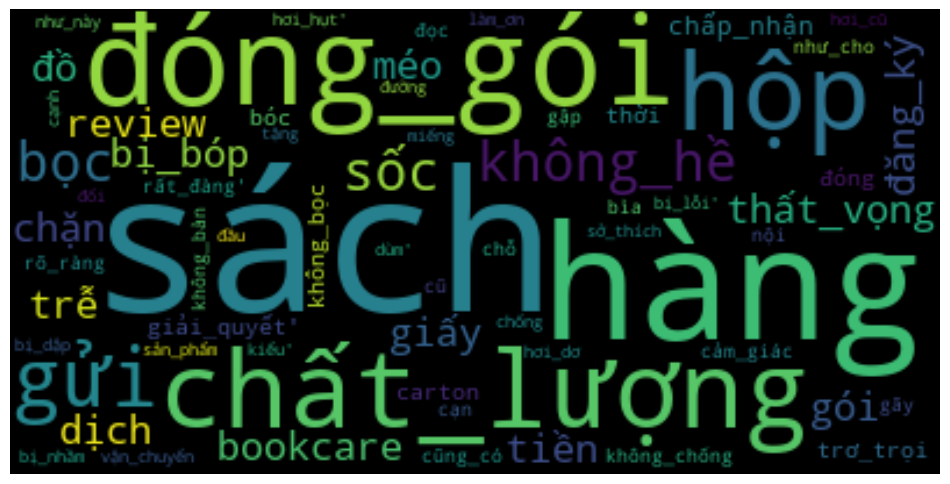

In [44]:
df_final_notlike = df_final[df_final['class'] == 'negative' ]
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
wc_notlike.generate(str(df_final_notlike['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

Neutral

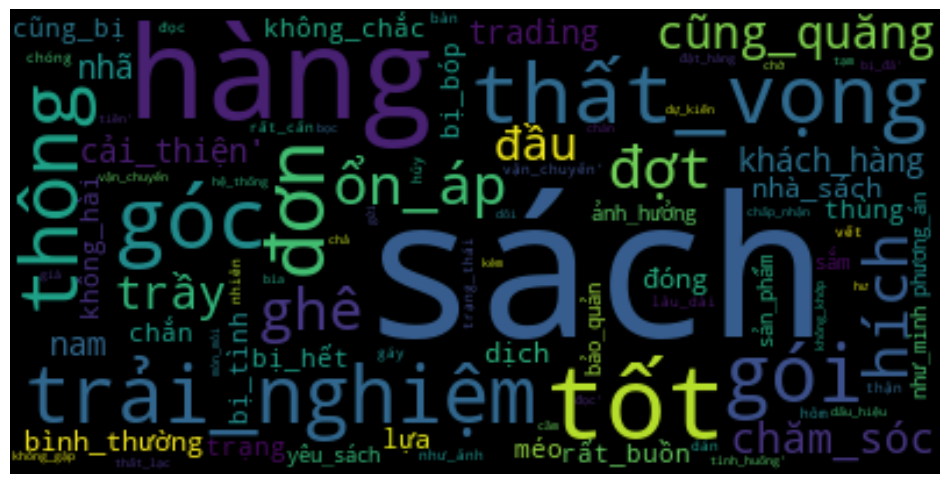

In [45]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
wc_neutral.generate(str(df_final_neutral['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive

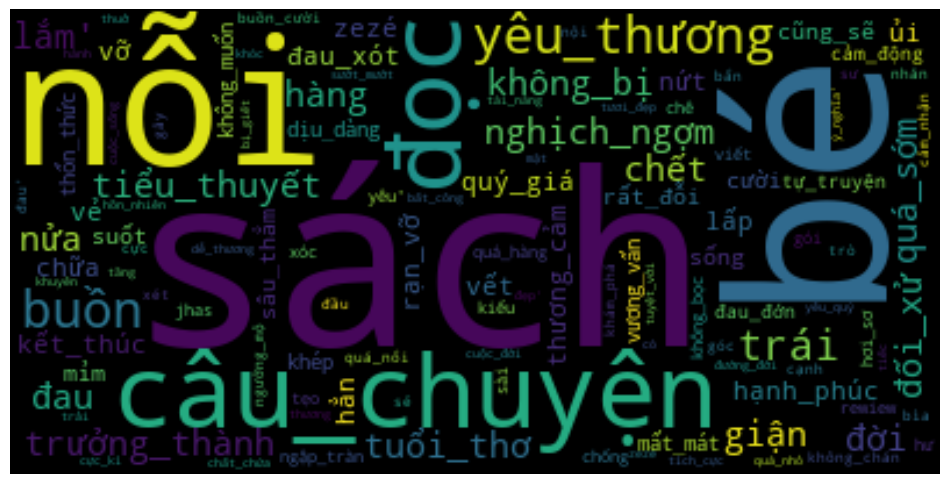

In [46]:
df_final_like = df_final[df_final['class'] == 'positive' ]
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
wc_like.generate(str(df_final_like['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()